# Import libraries

In [115]:
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression

from matplotlib import pyplot

# Fetching the data

In [2]:
EGR1_PATH = "./data/GA"
def load_egr1_data(file_path = EGR1_PATH):
    return pd.read_csv(file_path, sep="\t")

GENE_MAP_PATH = "./data/probeMap-hugo_refgene_good_hg18_probemap"
def load_gene_mapping(file_path = GENE_MAP_PATH):
    return pd.read_csv(file_path, sep="\t")

In [59]:
egr1_data_pre = load_egr1_data()
egr1_data_pre.head()

,sample,TCGA-AB-2880-03,TCGA-AB-2819-03,TCGA-AB-2875-03,TCGA-AB-2808-03,TCGA-AB-2848-03,TCGA-AB-2841-03,TCGA-AB-2910-03,TCGA-AB-2920-03,TCGA-AB-2986-03,...,TCGA-AB-2946-03,TCGA-AB-2999-03,TCGA-AB-2938-03,TCGA-AB-2913-03,TCGA-AB-2810-03,TCGA-AB-2924-03,TCGA-AB-2937-03,TCGA-AB-2966-03,TCGA-AB-3012-03,TCGA-AB-2954-03
0,UBE2Q1,4.5844,4.9574,4.6304,4.6482,4.5685,4.6315,4.8461,4.9947,5.1369,...,4.7872,4.6204,4.9043,4.5906,5.1216,4.7572,5.0893,5.0708,4.5537,4.6225
1,HIF3A,0.0039,0.7462,0.6472,0.0305,0.0206,0.0000,0.0068,0.0105,0.0062,...,0.0000,0.0377,0.1892,0.0342,0.0230,0.0158,3.3688,0.0541,0.0171,0.0126
2,RNF17,0.0338,0.0201,0.0000,0.0260,0.0263,0.0205,0.0178,0.0119,0.0000,...,0.0259,0.0345,0.0053,0.0404,0.0335,0.0000,0.0240,0.0334,0.0009,0.0014
3,RNF10,5.9150,5.5003,5.6430,5.7971,6.0917,6.3663,5.6803,6.0212,5.5240,...,5.5981,5.6837,5.7704,5.6478,6.4578,5.6424,5.9336,5.4772,5.9701,5.3745
4,RNF11,4.1399,4.7407,4.1058,4.8867,4.0516,4.7545,4.2329,3.7790,4.6918,...,4.2740,4.6785,4.7170,4.5241,5.2825,4.2691,5.0298,5.0714,5.0994,3.9462


In [5]:
gene_map = load_gene_mapping()
gene_map.head()

,id,gene,chrom,chromStart,chromEnd,strand,thickStart,thickEnd,blockCount,blockSizes,blockStarts
0,LOC100506869,LOC100506869,chr12,57271751,57492717,+,57492718,57492717,2,"167,255","0,220712"
1,LOC102724604,LOC102724604,chr3,182621645,182642968,-,182642969,182642968,5,"298,189,102,58,113","0,565,17435,18814,21211"
2,MTVR2,MTVR2,chr17,52316462,52317273,-,52317274,52317273,1,812,0
3,LOC100506860,LOC100506860,chr7,130248763,130257245,+,130257246,130257245,4,"162,141,233,411","0,1498,2436,8072"
4,LOC102724601,LOC102724601,chr1,172357399,172395048,-,172395049,172395048,4,"149,71,104,124","0,33989,37249,37526"


In [60]:
egr1_data_pre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20113 entries, 0 to 20112
Columns: 180 entries, sample to TCGA-AB-2954-03
dtypes: float64(179), object(1)
memory usage: 27.6+ MB


# Converting the data

In [10]:
def convert_dataset(data):
    data = data.transpose()
    new_header = data.iloc[0]
    data = data[1:]
    data.columns = new_header
    return data

In [65]:
# test = convert_dataset(egr1_data)
egr1_data_converted = convert_dataset(egr1_data_pre)
egr1_data_converted.head()

sample,UBE2Q1,HIF3A,RNF17,RNF10,RNF11,RNF13,LOC339240,REM1,REM2,SLC17A2,...,AP4M1,TULP2,NPY5R,METTL11B,GNGT1,PTRF,SERPINH1,NFIX,SELP,SELS
TCGA-AB-2880-03,4.5844,0.0039,0.0338,5.915,4.1399,4.26,0.0,0.0,0.5026,0.0,...,2.9415,0.8686,0.0,0.0,0.0168,0.0804,1.5128,2.8916,0.6694,3.6215
TCGA-AB-2819-03,4.9574,0.7462,0.0201,5.5003,4.7407,4.1842,0.0,0.0,0.1909,0.0,...,2.9003,1.6265,0.0,0.0,0.0,0.8562,2.9365,3.8729,1.1842,4.3103
TCGA-AB-2875-03,4.6304,0.6472,0.0,5.643,4.1058,4.1313,0.0,0.0351,0.3683,0.0129,...,3.2132,1.0523,0.0,0.0,0.0267,0.4259,2.4843,3.835,2.308,3.8222
TCGA-AB-2808-03,4.6482,0.0305,0.026,5.7971,4.8867,4.5314,0.0,0.0421,0.4949,0.0,...,2.5941,0.2723,0.0,0.0,0.0,0.7469,1.5096,3.085,1.949,3.7343
TCGA-AB-2848-03,4.5685,0.0206,0.0263,6.0917,4.0516,4.3099,0.0,0.0,1.6417,0.0,...,3.2031,0.5258,0.0,0.0,0.0,0.1641,2.2657,3.2528,0.8104,3.9934


In [49]:
def get_percentile(data_col, per):
    top = np.percentile(data_col, per)
    bottom = np.percentile(data_col, 100 - per)
    return top, bottom

# 0 if top x percent
# 1 if bottom x percent
def convert_to_binary(data_col):
    if data_col <= BOTTOM_PERCENTILE:
        return 0
    elif data_col >= TOP_PERCENTILE:
        return 1
    else:
        return np.nan

TCGA-AB-2880-03    NaN
TCGA-AB-2819-03    1.0
TCGA-AB-2875-03    1.0
TCGA-AB-2808-03    NaN
TCGA-AB-2848-03    1.0
                  ... 
TCGA-AB-2924-03    NaN
TCGA-AB-2937-03    NaN
TCGA-AB-2966-03    0.0
TCGA-AB-3012-03    1.0
TCGA-AB-2954-03    1.0
Name: EGR1, Length: 179, dtype: float64


In [66]:
data_egr1 = egr1_data_converted["EGR1"]

TOP_PERCENTILE, BOTTOM_PERCENTILE = get_percentile(data_egr1, 20)

binary_data_egr1 = data_egr1.apply(convert_to_binary)
egr1_data_converted.insert(1, "binary", binary_data_egr1)
egr1_data = egr1_data_converted.dropna()

In [72]:
egr1_data.head()
# egr1_data.tail()
# egr1_data.info()

sample,UBE2Q1,binary,HIF3A,RNF17,RNF10,RNF11,RNF13,LOC339240,REM1,REM2,...,AP4M1,TULP2,NPY5R,METTL11B,GNGT1,PTRF,SERPINH1,NFIX,SELP,SELS
TCGA-AB-2819-03,4.9574,1.0,0.7462,0.0201,5.5003,4.7407,4.1842,0.0,0.0,0.1909,...,2.9003,1.6265,0.0,0.0,0.0,0.8562,2.9365,3.8729,1.1842,4.3103
TCGA-AB-2875-03,4.6304,1.0,0.6472,0.0,5.643,4.1058,4.1313,0.0,0.0351,0.3683,...,3.2132,1.0523,0.0,0.0,0.0267,0.4259,2.4843,3.835,2.308,3.8222
TCGA-AB-2848-03,4.5685,1.0,0.0206,0.0263,6.0917,4.0516,4.3099,0.0,0.0,1.6417,...,3.2031,0.5258,0.0,0.0,0.0,0.1641,2.2657,3.2528,0.8104,3.9934
TCGA-AB-2910-03,4.8461,1.0,0.0068,0.0178,5.6803,4.2329,3.8292,0.0,0.0139,0.3354,...,3.7857,0.6967,0.0,0.0,0.0,0.4166,3.4542,2.389,0.2592,4.2829
TCGA-AB-2840-03,4.5787,1.0,2.1181,0.0,5.5728,4.4901,3.6361,0.0,0.0,0.6146,...,3.1909,0.4191,0.0,0.0,0.0,1.3965,3.5614,2.5854,0.2686,4.3416


# Separate training and testing sets

In [87]:
def get_xy_training_testing(dataframe):
    train_set, test_set = train_test_split(dataframe, test_size=0.4, random_state=42)
    X_train = train_set.drop("EGR1", axis=1)
    X_test = test_set.drop("EGR1", axis=1)
    y_train = train_set["binary"]
    y_test = test_set["binary"]
    return X_train, X_test, y_train, y_test
# len(train_set)
# len(test_set)

In [89]:
X_train, X_test, y_train, y_test = get_xy_training_testing(egr1_data)

<class 'pandas.core.frame.DataFrame'>
Index: 60 entries, TCGA-AB-2955-03 to TCGA-AB-2987-03
Columns: 20113 entries, UBE2Q1 to SELS
dtypes: float64(1), object(20112)
memory usage: 9.2+ MB


# SGDClassifier

In [100]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [102]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.85, 0.95, 1.  ])

# Logistic Regression

In [104]:
logistic_regr = LogisticRegression(random_state=42)
logistic_regr.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [108]:
predictions = logistic_regr.predict(X_test)

In [112]:
score = logistic_regr.score(X_test, y_test)
print(score)

1.0


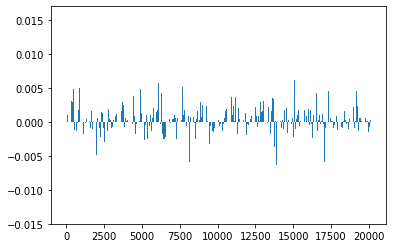

In [116]:
importance = logistic_regr.coef_[0]
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [ ]:
from sklearn.inspection import permutation_importance
r = permutation_importance(logistic_regr, X_test, y_test, n_repeats=30, random_state=42)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{egr1_data.feature_names[i]:<8}"f"{r.importances_mean[i]:.3f}"f" +/- {r.importances_std[i]:.3f}")